In [1]:
! pip install torch torchvision transformers clip-by-openai opencv-python numpy scikit-learn pillow matplotlib


INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.21.0-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)

The conflict is caused by:
    The user requested torch
    torchvision 0.12.0 depends on torch==1.11.0
    clip-by-openai 1.1 depends on torch<1.7.2 and >=1.7.1
    The user requested torch
    torchvision 0.12.0 depends on torch==1.11.0
    clip-by-openai 1.0.1 depends on torch<1.7.2 and >=1.7.1
 

ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1.1.3, clip-by-openai==0.1.1.4, clip-by-openai==0.1.1.5, clip-by-openai==1.0.1, clip-by-openai==1.1, torch and torchvision==0.12.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [13]:
import cv2
import numpy as np
from PIL import Image

def preprocess_for_cnn(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # 모델 입력 크기 맞춤
    
    # 대비 향상 (CLAHE 적용)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    # 윤곽선 강조 (Edge Detection)
    edges = cv2.Canny(img, 100, 200)
    
    # 가우시안 블러 적용 (노이즈 제거)
    img = cv2.GaussianBlur(img, (5, 5), 0)

    return Image.fromarray(img), edges  # CNN용 PIL 이미지 & 윤곽선 이미지 반환


In [ ]:
# 각각 이미지들이 서로 얼마나 유사한지 비교하는 방향으로 코드 좀 수정해야항듯 -> 수정완

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# ResNet 모델 로드
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Fully Connected Layer 제거
resnet.eval()

# 전처리: 대비 향상, 윤곽선 강조, 노이즈 제거
def preprocess_for_cnn(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # 대비 향상 (CLAHE 적용)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    # 윤곽선 강조
    edges = cv2.Canny(img, 100, 200)

    # 노이즈 제거 (Gaussian Blur)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return Image.fromarray(img), edges

# 특징 벡터 추출
def extract_cnn_features(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = resnet(img_tensor).squeeze().numpy()
    return features.flatten()

# 유사도 계산
def compute_cnn_similarity(gan_img1_path, gan_img2_path, re_img1_path, re_img2_path):
    gan_img1, gan_edges1 = preprocess_for_cnn(gan_img1_path) # gan 생성 이미지1
    gan_img2, gan_edges2 = preprocess_for_cnn(gan_img2_path) # gan 생성 이미지2

    re_img1, re_edges1 = preprocess_for_cnn(re_img1_path) # 추천 생성 이미지1
    re_img2, re_edges2 = preprocess_for_cnn(re_img2_path) # 추천 생성 이미지2

    gan_features1 = extract_cnn_features(gan_img1)
    gan_features2 = extract_cnn_features(gan_img2)

    re_features1 = extract_cnn_features(re_img1)
    re_features2 = extract_cnn_features(re_img2)

    # 유사도 계산
    cos_sim1 = cosine_similarity([gan_features1], [re_features1])[0][0]
    euclidean_dist1 = euclidean_distances([gan_features1], [re_features1])[0][0]
    manhattan_dist1 = manhattan_distances([gan_features1], [re_features1])[0][0]

    cos_sim2 = cosine_similarity([gan_features2], [re_features2])[0][0]
    euclidean_dist2 = euclidean_distances([gan_features2], [re_features2])[0][0]
    manhattan_dist2 = manhattan_distances([gan_features2], [re_features2])[0][0]

    return (cos_sim1, euclidean_dist1, manhattan_dist1), (cos_sim2, euclidean_dist2, manhattan_dist2)

gan_img1_path = "./ex_data/gan_1.png"
gan_img2_path = "./ex_data/gan_2.png"
re_img1_path = "./ex_data/c--88-_jpeg_jpg.rf.e1904e5f6ec8799cbb585551aafbaab1.jpg"
re_img2_path = "./ex_data/image_1.jpeg"

# 실행 예시
similarity1, similarity2 = compute_cnn_similarity(gan_img1_path, gan_img2_path, re_img1_path, re_img2_path)
print(f"GAN 이미지 1과 추천 가구 이미지 1의 유사도:")
print(f"  코사인 유사도: {similarity1[0]:.4f}")
print(f"  유클리드 거리: {similarity1[1]:.4f}")
print(f"  맨해튼 거리: {similarity1[2]:.4f}")

print(f"GAN 이미지 2과 추천 가구 이미지 2의 유사도:")
print(f"  코사인 유사도: {similarity2[0]:.4f}")
print(f"  유클리드 거리: {similarity2[1]:.4f}")
print(f"  맨해튼 거리: {similarity2[2]:.4f}")

GAN 이미지 1과 추천 가구 이미지 1의 유사도:
  코사인 유사도: 0.5565
  유클리드 거리: 23.3311
  맨해튼 거리: 718.8467
GAN 이미지 2과 추천 가구 이미지 2의 유사도:
  코사인 유사도: 0.6743
  유클리드 거리: 22.2700
  맨해튼 거리: 681.9599


In [15]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from itertools import product  # 모든 쌍을 자동으로 생성

# ResNet 모델 로드
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Fully Connected Layer 제거
resnet.eval()

# 전처리: 대비 향상, 윤곽선 강조, 노이즈 제거
def preprocess_for_cnn(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # 대비 향상 (CLAHE 적용)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    # 윤곽선 강조
    edges = cv2.Canny(img, 100, 200)

    # 노이즈 제거 (Gaussian Blur)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return Image.fromarray(img), edges

# 특징 벡터 추출
def extract_cnn_features(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = resnet(img_tensor).squeeze().numpy()
    return features.flatten()

# 유사도 계산 함수 (하나의 쌍에 대해)
def compute_similarity(vec1, vec2):
    return {
        "cosine_similarity": cosine_similarity([vec1], [vec2])[0][0],
        "euclidean_distance": euclidean_distances([vec1], [vec2])[0][0],
        "manhattan_distance": manhattan_distances([vec1], [vec2])[0][0]
    }

# 모든 조합에 대한 유사도 계산
def compute_all_pairwise_cnn_similarity(gan_img_paths, re_img_paths):
    feature_cache = {}  # 특징 벡터 저장 (중복 계산 방지)

    # 모든 이미지의 특징 벡터 추출 및 저장
    for img_path in gan_img_paths + re_img_paths:
        img, _ = preprocess_for_cnn(img_path)  # 윤곽선 이미지는 사용하지 않음
        feature_cache[img_path] = extract_cnn_features(img)

    # 모든 조합 비교 (GAN 이미지 ↔ 추천 이미지)
    similarity_results = {}
    for gan_img, re_img in product(gan_img_paths, re_img_paths):
        similarity_results[f"{gan_img} ↔ {re_img}"] = compute_similarity(feature_cache[gan_img], feature_cache[re_img])

    return similarity_results

# 실행 예시
gan_img_paths = ["./ex_data/gan_1.png", "./ex_data/gan_2.png"]
re_img_paths = ["./ex_data/image_115.jpeg", "./ex_data/image_1.jpeg"]

similarity_results = compute_all_pairwise_cnn_similarity(gan_img_paths, re_img_paths)

# 결과 출력
for pair, values in similarity_results.items():
    print(f"{pair} 유사도:")
    print(f"  코사인 유사도: {values['cosine_similarity']:.4f}")
    print(f"  유클리드 거리: {values['euclidean_distance']:.4f}")
    print(f"  맨해튼 거리: {values['manhattan_distance']:.4f}\n")


c:\Users\LG\elice\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LG\elice\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


./ex_data/gan_1.png ↔ ./ex_data/image_115.jpeg 유사도:
  코사인 유사도: 0.7599
  유클리드 거리: 20.2203
  맨해튼 거리: 621.0223

./ex_data/gan_1.png ↔ ./ex_data/image_1.jpeg 유사도:
  코사인 유사도: 0.7191
  유클리드 거리: 20.8076
  맨해튼 거리: 645.2655

./ex_data/gan_2.png ↔ ./ex_data/image_115.jpeg 유사도:
  코사인 유사도: 0.6752
  유클리드 거리: 23.2347
  맨해튼 거리: 726.8759

./ex_data/gan_2.png ↔ ./ex_data/image_1.jpeg 유사도:
  코사인 유사도: 0.6743
  유클리드 거리: 22.2700
  맨해튼 거리: 681.9599



c:\Users\LG\elice\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LG\elice\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


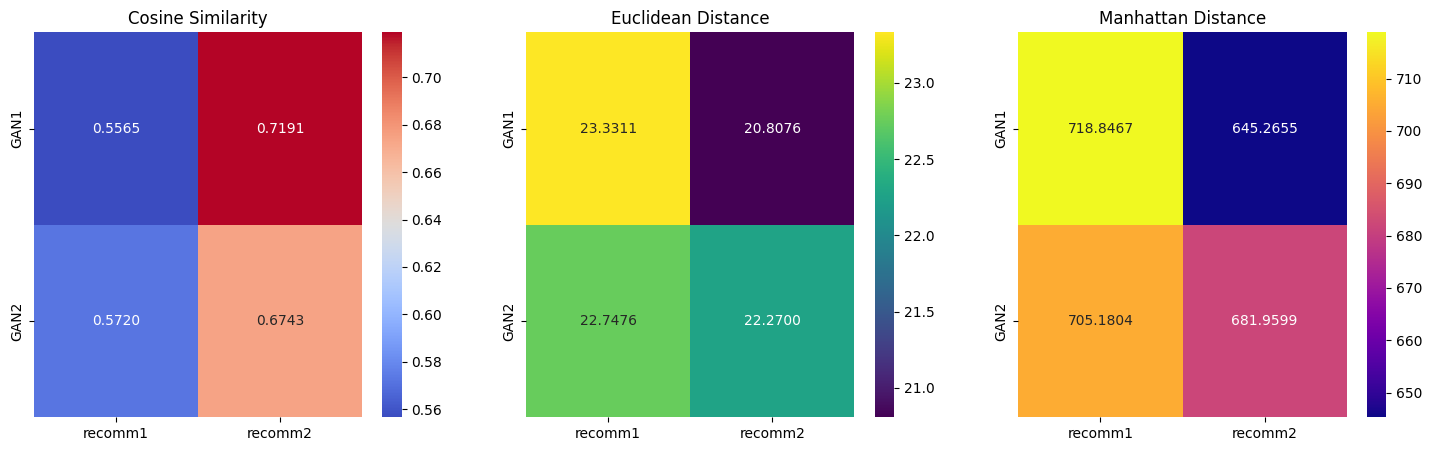

In [17]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from itertools import product  # 모든 쌍을 자동으로 생성

# ResNet 모델 로드
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Fully Connected Layer 제거
resnet.eval()

# 전처리: 대비 향상, 윤곽선 강조, 노이즈 제거
def preprocess_for_cnn(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # 대비 향상 (CLAHE 적용)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

    # 윤곽선 강조
    edges = cv2.Canny(img, 100, 200)

    # 노이즈 제거 (Gaussian Blur)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return Image.fromarray(img), edges

# 특징 벡터 추출
def extract_cnn_features(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = resnet(img_tensor).squeeze().numpy()
    return features.flatten()

# 유사도 계산 함수
def compute_similarity(vec1, vec2):
    return {
        "cosine_similarity": cosine_similarity([vec1], [vec2])[0][0],
        "euclidean_distance": euclidean_distances([vec1], [vec2])[0][0],
        "manhattan_distance": manhattan_distances([vec1], [vec2])[0][0]
    }

# 모든 조합에 대한 유사도 계산
def compute_all_pairwise_cnn_similarity(gan_img_paths, re_img_paths):
    feature_cache = {}  # 특징 벡터 저장 (중복 계산 방지)

    # 모든 이미지의 특징 벡터 추출 및 저장
    for img_path in gan_img_paths + re_img_paths:
        img, _ = preprocess_for_cnn(img_path)  # 윤곽선 이미지는 사용하지 않음
        feature_cache[img_path] = extract_cnn_features(img)

    # 모든 조합 비교 (GAN 이미지 ↔ 추천 이미지)
    similarity_results = {}
    for gan_img, re_img in product(gan_img_paths, re_img_paths):
        similarity_results[f"{gan_img} ↔ {re_img}"] = compute_similarity(feature_cache[gan_img], feature_cache[re_img])

    return similarity_results

# 유사도 행렬 시각화
def plot_similarity_heatmaps(similarity_results, gan_img_paths, re_img_paths):
    # 행렬을 만들기 위해 리스트 변환
    cosine_matrix = []
    euclidean_matrix = []
    manhattan_matrix = []

    for gan_img in gan_img_paths:
        cosine_row = []
        euclidean_row = []
        manhattan_row = []

        for re_img in re_img_paths:
            key = f"{gan_img} ↔ {re_img}"
            cosine_row.append(similarity_results[key]["cosine_similarity"])
            euclidean_row.append(similarity_results[key]["euclidean_distance"])
            manhattan_row.append(similarity_results[key]["manhattan_distance"])

        cosine_matrix.append(cosine_row)
        euclidean_matrix.append(euclidean_row)
        manhattan_matrix.append(manhattan_row)

    labels_x = [f"recomm{i+1}" for i in range(len(re_img_paths))]
    labels_y = [f"GAN{i+1}" for i in range(len(gan_img_paths))]

    # 히트맵 그리기
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(cosine_matrix, annot=True, fmt=".4f", cmap="coolwarm", xticklabels=labels_x, yticklabels=labels_y, ax=axes[0])
    axes[0].set_title("Cosine Similarity")

    sns.heatmap(euclidean_matrix, annot=True, fmt=".4f", cmap="viridis", xticklabels=labels_x, yticklabels=labels_y, ax=axes[1])
    axes[1].set_title("Euclidean Distance")

    sns.heatmap(manhattan_matrix, annot=True, fmt=".4f", cmap="plasma", xticklabels=labels_x, yticklabels=labels_y, ax=axes[2])
    axes[2].set_title("Manhattan Distance")

    plt.show()

# 실행 예시
gan_img_paths = ["./ex_data/gan_1.png", "./ex_data/gan_2.png"]
re_img_paths = ["./ex_data/c--88-_jpeg_jpg.rf.e1904e5f6ec8799cbb585551aafbaab1.jpg", "./ex_data/image_1.jpeg"]

similarity_results = compute_all_pairwise_cnn_similarity(gan_img_paths, re_img_paths)

# 시각화 실행
plot_similarity_heatmaps(similarity_results, gan_img_paths, re_img_paths)
